# Cell Phone Dataset Experiment
This notebook is aimed at testing the capabilities of the class differentiation measure for the case of a more general dataset. In this case we are going to analyse the case of a Cell Phone dataset classification problem. From the results obtained in the previous experiment, a new approach is intended. In this case, the intersection of the representations of two sets is measured in a different way.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
import gc
from pathlib import Path
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler



        

In [3]:
# Magics first (server issues)

# if you want static matplotlib plot :
#%matplotlib inline 
# Do below if you want interactive matplotlib plot :
%matplotlib notebook 

# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
#Customisations


#Any tweaks that normally go in .matplotlibrc, etc. should explicity go here
plt.rcParams['figure.figsize'] = (7,5)
%config InlineBackend.figure_format='retina'

### Functions

In [4]:
def distance_to_point(point,array):
    dist = []
    for i in range(array.shape[0]):
        d = np.linalg.norm(point-array[i])
        dist.append(d)
    return np.array(dist)

def distance_factor(sample,mode = 0):
    """
    This function computes the relative contrast provided by the paper  "ON the suprising behaviour". 
    In this case, the relative constras will be computed with respect the mean.
    
    Parameters:
    ----------
    sample: Dataset from which the relative factor must be computed.
    mode: working mode. Default:0
    
    Return
    ------
    rt : Relative contrast.
    """
    if mode == 0:
        dt = centroid_distance(sample)
        m = np.min(dt)
        M = np.max(dt)
        rt = (M-m)/m
        return rt
    

def mahalanobis(array,observations):
    """
    This function computes the Mahalanobis "Norm" of a provided vector array and a provided set of
     observations
    
    Parameters
    ----------
    array: Provided array. This distance will provide a measure of how much this vector belongs to
    the provided set of vectors.
    observations: Set of previous observations.
    
    Return
    ------
    Mahalanobis distance to the provided set.
    
    """
    observations = np.transpose(observations)
    #print(f'Observations shape: {observations.shape}')
    mean = np.mean(observations,axis = 1)
    #print(f'Mean  {mean}')
    cov = np.cov(observations)
    inv_cov = np.linalg.inv(cov)
    #print(f'Cov: {cov}')
    v = array - mean
    distance = np.sqrt(np.matmul(np.matmul(v,inv_cov),v))
    return distance

def d_mahalanobis_distance(sample):
    """
    This function computes the mahalanobis distance of each single point to itself
    
    Parameters
    ----------
    sample. samples or dataset used to compute the mahalanobis distance.
    
    Return
    ------
    d_v: distance vector
    """
    d_v = []
    for i in sample:
        d_v.append(mahalanobis(i,sample))
    d_v = np.array(d_v)
    return d_v

def centroid_distance(sample):
    """
    This function computes the distance from the mass center of a given set to each other point
    
    Parameter
    ---------
    sample: sample of elements on which the method will be applied.
    
    Return
    ------
    d_v: distance vector
    """
    m = np.mean(sample,axis=0)
    d_v=distance_to_point(m,sample)
    return d_v

def density_funct_estimation(sample,density_factor=100):
    """
    This function computes the density estimation associated to a category in a
    dataset.
    """
    q = []
    for i in range(1,density_factor):
        q.append(np.quantile(sample,i/density_factor))
    q = np.array(q)
    q = np.concatenate((np.array([np.min(sample)]),q,np.array([np.max(sample)])))
    dq = np.diff(q)
    h = (1/density_factor)/dq

    return q[1:],h

def quantile_entropy(density_vector):
    """
    This function computes the entropy associated to a simple density function made out of constant values
    obtained for equally spaciated quantiles.
    
    Parameters
    ----------
    density_vector: array. Vector containing the densities obtained for a specific sample.
    
    Return
    ------
    qe: Scalar value associated to the entropy of the sample.
    
    """
    c = 1/density_vector.shape[0]
    qe = (-c)*np.sum(np.log(density_vector))
    return qe
def n_sphere_vol(r,dim = 2):
    if dim%2 == 0:
        k = dim/2
        volume = ((np.pi**k)/np.math.factorial(k))*r**dim
    elif dim%2 == 1:
        k = dim//2
        volume = ((2*np.math.factorial(k)*(4*np.pi)**k)/(np.math.factorial(dim)))*r**dim     
    return volume

def mutual_density(target_random_sample, non_target_random_sample,non_target_quantiles ):
    """
    This function computes the empirical probability measure of the intersection of two 
    categories within a dataset.
    
    Params
    --------
    target_random_sample: np.array. Samples that belongs to the target category. The
                          probability measure will be computed with respect the empirical
                          probability distribution associated to this category.
    non_target_random_sample: np.array. Samples that belong to some other category. If 
                          these two categories are not disjoint then the intersection will
                          be a measurable set and its measure can be computed with respect
                          the different probability measures.
    non_target_quantiles: np.array. Array that contains the quantiles of distances with respect
                          the non_target_random_sample.
                          
    Return
    -------
    m: float. Measure of the intersection of the two categories with respect the empirical prob
              bability measure defined for the target_random_sample-
    """
    
    r = non_target_quantiles[-1]
    c2 = np.mean(non_target_random_sample,axis=0)
    distances_to_c2 = distance_to_point(point = c2,array = target_random_sample)
    categories_intersection = distances_to_c2[np.where(distances_to_c2<=r)]
    m = categories_intersection.shape[0]/target_random_sample.shape[0]
    return m

def intersection_divergence_entropy(dataset_1,dataset_2):
    """
    Test
    """
    distances1 = centroid_distance(dataset_1)
    distances2 = centroid_distance(dataset_2)
    q1,h1 = density_funct_estimation(distances1)
    q2,h2 = density_funct_estimation(distances2)
    m1 = mutual_density(dataset_1,dataset_2,q2)
    m2 = mutual_density(dataset_2,dataset_1,q1)
    i_d_e = m1*np.log(m1/m2)
    return i_d_e

def mutual_density_divergence(target_category, category_list):
    """
    This function computes a coefficient associated to the measure of
    the intersections of a measurable set with respect someother measurable sets 
    for a set of probability measures. This coefficient intends to provide insights 
    of the average 'size'of these intersections and, in that way, how distinguishable
    is a set from others.
    
    Parameters
    -----------
    target_category: array. Dataset associated to the target category for which the coe-
                     fficient will be computed.
    category_list: list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    mode: int. Used mean method. Default:0 Arithmetic mean. 1, geometric mean.
    
    Return
    -------
    phi: float. Coefficient associated to the target category.
    
    """

    relative_measures = []
    for category in category_list:
        d = centroid_distance(category)
        q,h = density_funct_estimation(d)
        m=mutual_density(target_category,category,q)
        relative_measures.append(m)
    relative_measures = np.array(relative_measures)
    phi = np.mean(np.log(1/(1-relative_measures)))
    return phi, relative_measures

def dataset_density_function_estimation(dataset):
    d = centroid_distance(dataset)
    q,h = density_funct_estimation(d)
    return q,h

def dataset_quantile_entropy(dataset):
    q,h = dataset_density_function_estimation(dataset)
    e = quantile_entropy(h)
    return e
def mean_categorical_entropy(category_list):
    """
    This function computes the mean categorical entropy defined for n categories in
    a classification problem as (phi1*h1+...+phin*hn)/n
    
    Parameters
    -----------
    
    category_list:list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    
    Return
    --------
    mce:float. Mean Cathegorical Entropy. 
    """
    entropies = []
    mdd_coefficients=[]
    
    for i in  range(category_list.shape[0]):
        quantile_entropy = dataset_quantile_entropy(category_list[i])
        entropies.append(quantile_entropy)
        target_category = category_list[i]
        non_target_category = np.delete(category_list,i,axis = 0)
        #print(f'shape {non_target_category.shape}')
        phi,_relative_measures = mutual_density_divergence(target_category = target_category,category_list = non_target_category)
        print(f'Relative Measures {_relative_measures}')
        print(f'Coefficients {phi}')
        mdd_coefficients.append(phi)
    entropies = np.array(entropies)
    mdd_coefficients = np.array(mdd_coefficients)    
    mce = np.mean(100*np.log2(mdd_coefficients)+entropies)
    return mce



def category_finder(training_dataset,category_column):
    """
    This function takes a pandas DataFrame training_dataset as 
    input and returns a set of pandas DataFrame each associated 
    to a specific category
    
    Parameters
    ----------
    training_dataset: Pandas DataFrame. DataFrame that contains the
                      training dataset
    category_columns: str. Name of the column that contains the 
    categories
    
    Returns: category_dict. Dictionary that contains the different
            categories dataframes
    """
    category_dict = {}
    categories = training_dataset[category_column].unique()
    #print(f'Unique Values: {categories}')
    for i in range(categories.shape[0]):
        #print(f'Categoria: {categories[i]}')
        name = categories[i]
        current_df = training_dataset.loc[training_dataset[category_column]==categories[i]].copy()
        category_dict[name]= current_df
    return category_dict

def mean_mutual_density_divergence(dataset,representation_columns,category_column):
    """
    this function computes the mean mutual density divergence.
    
    Parameters
    ----------
    dataset: pandas DataFrame. dataset that is going to be used for training the model (
             all columns must be included)
    representation_columns: list of str. Names of the columns that stand for the representation,
                          i.e. the feature columns
    category_column: str. Name of the column that contains the categories
    
    Return
    ------
    mean_phi: float. Mean of the phi values associated to the different mutual density divergence
    
    phis: list of float. List of phi values associated to the different mutual density divergence
    
    """
    
    categories = category_finder(dataset,category_column)
    categories_names = list(categories.keys())
    phis = []
    for i in range(len(categories_names)):
        remaining_category_names = categories_names.copy()
        target_category_name = categories_names[i]
        remaining_category_names.remove(target_category_name)
        #print(f'Target Category Name: {target_category_name}')
        #print(f'Remaining Category Name: {remaining_category_names}')
        #computing the divergence
        target_X = categories[target_category_name][representation_columns].values
        #print(f'This is target_X: { target_X}')
        complementary_targets = [categories[name][representation_columns].values for name in remaining_category_names]
        #print(f'These are complementary targets: {complementary_targets}')
        
        phi,rm = mutual_density_divergence(target_category=target_X, category_list=complementary_targets)
        phis.append(phi)
        #print(f'Mean phi:{np.mean(phis)}\nList of phis: {phis}')
        
        del remaining_category_names
    return np.mean(phis),phis

def average_inner_distance(target_points, data):
    """
    This function compute the average distance from a representation
    of a set called data to a series of target points.
    
    Parameters
    ----------
    target_points: np.array. Array of target points. These points are 
                   the reference points for computing the average distance.
    data: np.array. Array associated to the data points for a especific 
                    representation.
                    
    Return
    ------
    mean_dist: float. Mean distance to the different points
    std_dist:  float. Standard deviation of the distances.
    """
    distances_array = np.zeros(shape=(target_points.shape[0],data.shape[0],target_points.shape[1]))
    for i in range(target_points.shape[0]):
        distances_array[i]= target_points[i] - data
    d = np.linalg.norm(distances_array,axis = 2)
    m_d = np.min(d,axis = 1)
    mean_dist = np.mean(m_d)
    std_dist = np.std(m_d)
    return mean_dist, std_dist
    
    
def dataset_intersection_counter(target_reference_points, radius, target_dataset):
    """
    This function counts the number of points of a target dataset inside the covering
    defined by the balls of centers in target_reference_points (coming from a reference dataset)
    with radius radius.
    The idea is to detect if two given datasets the intersectionis void or not.
    
    Parameters
    ----------
    target_reference_points: np.array. Array of target points. These points come from the targe dataset of
                   reference.
    radius: float. Radius of the balls
    target_dataset: np.array. Array of points associated to someother dataset whose intersection 
    with the reference dataset wants to be computed.
    
    Returns
    -------
    intersection_measure: float. This value is the number of target reference points that have points 
                          of target dataset inside a ball of center a target_point and radius radius.
    """
    distances_array = np.zeros(shape=(target_reference_points.shape[0],target_dataset.shape[0],target_reference_points.shape[1]))
    for i in range(target_reference_points.shape[0]):
        distances_array[i]= target_reference_points[i] - target_dataset
    d = np.linalg.norm(distances_array,axis = 2)
    n_intersection_indexes = np.unique(np.where(d <= radius)[0]).shape[0]
    intersection_measure = n_intersection_indexes/target_reference_points.shape[0]
    return intersection_measure
    

In [5]:
def average_inner_distance(target_points, data):
    """
    This function compute the average distance from a representation
    of a set called data to a series of target points.
    
    Parameters
    ----------
    target_points: np.array. Array of target points. These points are 
                   the reference points for computing the average distance.
    data: np.array. Array associated to the data points for a especific 
                    representation.
                    
    Return
    ------
    mean_dist: float. Mean distance to the different points
    std_dist:  float. Standard deviation of the distances.
    """
    distances_array = np.zeros(shape=(target_points.shape[0],data.shape[0],target_points.shape[1]))
    for i in range(target_points.shape[0]):
        distances_array[i]= target_points[i] - data
    d = np.linalg.norm(distances_array,axis = 2)
    m_d = np.min(d,axis = 1)
    mean_dist = np.mean(m_d)
    std_dist = np.std(m_d)
    return mean_dist, std_dist
    
    
def dataset_intersection_counter(target_reference_points, radius, target_dataset):
    """
    This function counts the number of points of a target dataset inside the covering
    defined by the balls of centers in target_reference_points (coming from a reference dataset)
    with radius radius.
    The idea is to detect if two given datasets the intersectionis void or not.
    
    Parameters
    ----------
    target_reference_points: np.array. Array of target points. These points come from the targe dataset of
                   reference.
    radius: float. Radius of the balls
    target_dataset: np.array. Array of points associated to someother dataset whose intersection 
    with the reference dataset wants to be computed.
    
    Returns
    -------
    intersection_measure: float. This value is the number of target reference points that have points 
                          of target dataset inside a ball of center a target_point and radius radius.
    """
    distances_array = np.zeros(shape=(target_reference_points.shape[0],target_dataset.shape[0],target_reference_points.shape[1]))
    for i in range(target_reference_points.shape[0]):
        distances_array[i]= target_reference_points[i] - target_dataset
    d = np.linalg.norm(distances_array,axis = 2)
    n_intersection_indexes = np.unique(np.where(d <= radius)[0]).shape[0]
    intersection_measure = n_intersection_indexes/target_reference_points.shape[0]
    return intersection_measure


def mutual_density_divergence_2(target_category, category_list):
    """
    This function computes a coefficient associated to the measure of
    the intersections of a measurable set with respect someother measurable sets 
    for a set of probability measures. This coefficient intends to provide insights 
    of the average 'size'of these intersections and, in that way, how distinguishable
    is a set from others.
    
    Parameters
    -----------
    target_category: array. Dataset associated to the target category for which the coe-
                     fficient will be computed.
    category_list: list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    mode: int. Used mean method. Default:0 Arithmetic mean. 1, geometric mean.
    
    Return
    -------
    phi: float. Coefficient associated to the target category.
    
    """
    cpr = 0.2#Control Points Rate
    relative_measures = []
    control_points = target_category[:int(cpr*target_category.shape[0])]
    reference_data = target_category[int(cpr*target_category.shape[0]):]
    mn,s = average_inner_distance(target_points = control_points, data = reference_data)
    for category in category_list:
        m = dataset_intersection_counter(target_reference_points = control_points, radius = mn+2*s, target_dataset=category)
        relative_measures.append(m)
    relative_measures = np.array(relative_measures)
    phi = np.mean(np.log(1/(1-relative_measures)))
    return phi, relative_measures

def mean_mutual_density_divergence_2(dataset,representation_columns,category_column):
    """
    this function computes the mean mutual density divergence.
    
    Parameters
    ----------
    dataset: pandas DataFrame. dataset that is going to be used for training the model (
             all columns must be included)
    representation_columns: list of str. Names of the columns that stand for the representation,
                          i.e. the feature columns
    category_column: str. Name of the column that contains the categories
    
    Return
    ------
    mean_phi: float. Mean of the phi values associated to the different mutual density divergence
    
    phis: list of float. List of phi values associated to the different mutual density divergence
    
    """
    
    categories = category_finder(dataset,category_column)
    categories_names = list(categories.keys())
    phis = []
    for i in range(len(categories_names)):
        remaining_category_names = categories_names.copy()
        target_category_name = categories_names[i]
        remaining_category_names.remove(target_category_name)
        #print(f'Target Category Name: {target_category_name}')
        #print(f'Remaining Category Name: {remaining_category_names}')
        #computing the divergence
        target_X = categories[target_category_name][representation_columns].values
        #print(f'This is target_X: { target_X}')
        complementary_targets = [categories[name][representation_columns].values for name in remaining_category_names]
        #print(f'These are complementary targets: {complementary_targets}')
        
        phi,rm = mutual_density_divergence_2(target_category=target_X, category_list=complementary_targets)
        phis.append(phi)
        print(f'Relative measures: {rm}')
        #print(f'Mean phi:{np.mean(phis)}\nList of phis: {phis}')
        
        del remaining_category_names
    return np.mean(phis),phis
    

### Parameters

In [6]:
p = Path('./datasets/cell_phone_train.csv')
p_test = Path('./datasets/cell_phone_test.csv')
scaler = MinMaxScaler()
#columns = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']

### Control Dataset

In [7]:
data = pd.read_csv(p).sample(frac=1)
test_data = pd.read_csv(p_test)
print(data.head())
columns = list(data.columns)[:-1]
target_column = list(data.columns)[-1]
print(f'Data Shape: {data.shape}')

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
1371            601     1          1.7         1   3       1           6   
1861           1189     1          1.9         0   5       0           7   
1044           1218     1          2.8         1   3       0          39   
1701           1306     1          2.1         1   2       1          33   
13              803     1          2.1         0   7       0          17   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
1371    0.8        169        4  ...        818      1827  2651    14     8   
1861    0.5        164        2  ...         79       615   841    13    10   
1044    0.8        150        7  ...       1122      1746  1667    10     0   
1701    0.4        174        3  ...        867      1258  2521     6     5   
13      1.0        198        4  ...        344      1440  2680     7     1   

      talk_time  three_g  touch_screen  wifi  price_range  
1371    

In [8]:
data[target_column].value_counts()

2    500
0    500
1    500
3    500
Name: price_range, dtype: int64

In [9]:

scaled_data = data.copy()
scaled_data[columns] = scaler.fit_transform(scaled_data[columns])
X = scaled_data[columns]
Y = scaled_data[target_column]
t_r = 0.7

X_training = X.iloc[:int(t_r*X.shape[0])]
X_test = X.iloc[int(t_r*X.shape[0]):]
Y_training = Y.iloc[:int(t_r*Y.shape[0])]
Y_test = Y.iloc[int(t_r*Y.shape[0]):]

In [10]:
print(f'Data: {data.head()}\nX:{X.head()}')

Data:       battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
1371            601     1          1.7         1   3       1           6   
1861           1189     1          1.9         0   5       0           7   
1044           1218     1          2.8         1   3       0          39   
1701           1306     1          2.1         1   2       1          33   
13              803     1          2.1         0   7       0          17   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
1371    0.8        169        4  ...        818      1827  2651    14     8   
1861    0.5        164        2  ...         79       615   841    13    10   
1044    0.8        150        7  ...       1122      1746  1667    10     0   
1701    0.4        174        3  ...        867      1258  2521     6     5   
13      1.0        198        4  ...        344      1440  2680     7     1   

      talk_time  three_g  touch_screen  wifi  price_range  
13

### Models

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(32,64,64,16),random_state=1, max_iter=200)
gbc = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0,max_depth=1, random_state=0)


### Control Dataset information analysis. Old intersection measure

In [12]:
mphi,phis = mean_mutual_density_divergence(data.iloc[:int(t_r*data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')


---------------------------------
---------------------------------
Mean phi: inf
---------------------------------
---------------------------------
Phi list: [1.5723564524624833, 2.3047837085134995, 1.9411172033861268, inf]


/tmp/ipykernel_6492/634881167.py:204: RuntimeWarning: divide by zero encountered in true_divide
  phi = np.mean(np.log(1/(1-relative_measures)))


### Control Dataset information analysis. New intersection measure

In [13]:
mphi,phis = mean_mutual_density_divergence_2(data.iloc[:int(t_r*data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')

Relative measures: [0.         0.26086957 0.2173913 ]
Relative measures: [0.         0.16216216 0.        ]
Relative measures: [0.34285714 0.14285714 0.        ]
Relative measures: [0.27272727 0.         0.        ]
---------------------------------
---------------------------------
Mean phi: 0.13473269121425446
---------------------------------
---------------------------------
Phi list: [0.1824677766353062, 0.05897690271969275, 0.19133484179584073, 0.10615124370617819]


### Model Training on Control Dataset
#### Multi-layer Perceptron

In [14]:
mlp.fit(X_training,Y_training)

/home/luis_munoz/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 64, 64, 16), random_state=1)

#### Model Ensemble

In [15]:
gbc.fit(X_training,Y_training)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=150,
                           random_state=0)

#### Scoring

In [16]:
print(f'Mean phi: {mphi}')
print(f'Phi list: {phis}')
print(f'Scoring MLP: {mlp.score(X_test,Y_test)}')
print(f'Scoring GBC: {gbc.score(X_test,Y_test)}')

Mean phi: 0.13473269121425446
Phi list: [0.1824677766353062, 0.05897690271969275, 0.19133484179584073, 0.10615124370617819]
Scoring MLP: 0.9133333333333333
Scoring GBC: 0.91


#### Confusion Matrix

In [24]:
print(f'Confusion Matrix MLP:\n{confusion_matrix(mlp.predict(X_test),Y_test,normalize = "true")}')


Confusion Matrix MLP:
[[0.92592593 0.07407407 0.         0.        ]
 [0.03472222 0.89583333 0.06944444 0.        ]
 [0.         0.04666667 0.89333333 0.06      ]
 [0.         0.         0.06432749 0.93567251]]


### Modified dataset
Random shuffle

In [16]:
modified_data = data[columns].copy().sample(frac = 1)
print(modified_data.head())

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
485            1277     0          3.0         0   0       1          41   
989             559     1          0.5         0  10       0          11   
157            1224     0          0.5         0  16       1           6   
1088           1655     1          0.5         1   6       1           4   
1298           1089     0          1.4         1  10       0           2   

      m_dep  mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  \
485     0.3        200        4   3        902      1090   429     9     4   
989     0.4         82        5  14        541       823  2019    10     4   
157     0.4        109        6  18        747       826   506    10     0   
1088    0.1        105        3  12        626      1348   673    10     3   
1298    0.1        153        7  20        211      1409  2620     7     5   

      talk_time  three_g  touch_screen  wifi  
485          14        1   

In [18]:
modified_data[target_column]= data[target_column].values.copy()
print(modified_data.head())

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
485            1277     0          3.0         0   0       1          41   
989             559     1          0.5         0  10       0          11   
157            1224     0          0.5         0  16       1           6   
1088           1655     1          0.5         1   6       1           4   
1298           1089     0          1.4         1  10       0           2   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
485     0.3        200        4  ...        902      1090   429     9     4   
989     0.4         82        5  ...        541       823  2019    10     4   
157     0.4        109        6  ...        747       826   506    10     0   
1088    0.1        105        3  ...        626      1348   673    10     3   
1298    0.1        153        7  ...        211      1409  2620     7     5   

      talk_time  three_g  touch_screen  wifi  price_range  
485     

In [20]:
modified_scaled_data = modified_data.copy()
modified_scaled_data[columns] = scaler.fit_transform(modified_scaled_data[columns])
modified_X = modified_scaled_data[columns]
modified_Y = modified_scaled_data[target_column]
t_r = 0.7

modified_X_training = modified_X.iloc[:int(t_r*modified_X.shape[0])]
modified_X_test = modified_X.iloc[int(t_r*modified_X.shape[0]):]
modified_Y_training = modified_Y.iloc[:int(t_r*modified_Y.shape[0])]
modified_Y_test = modified_Y.iloc[int(t_r*modified_Y.shape[0]):]

### Models for modified dataset

In [21]:
mmlp = MLPClassifier(hidden_layer_sizes=(8,16,8,),random_state=1, max_iter=200)
mgbc = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0,max_depth=1, random_state=0)

### Modified Dataset Information Analysis. Old intersection measure.

In [23]:
mphi,phis = mean_mutual_density_divergence(modified_data.iloc[:int(t_r*modified_data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')

---------------------------------
---------------------------------
Mean phi: inf
---------------------------------
---------------------------------
Phi list: [inf, inf, inf, inf]


/tmp/ipykernel_7403/634881167.py:204: RuntimeWarning: divide by zero encountered in true_divide
  phi = np.mean(np.log(1/(1-relative_measures)))


### Modified Dataset Information Analysis. New intersection measure.

In [24]:
mphi,phis = mean_mutual_density_divergence_2(modified_data.iloc[:int(t_r*modified_data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')

Relative measures: [0.95833333 0.95833333 0.98611111]
Relative measures: [1.         0.95714286 0.95714286]
Relative measures: [0.97058824 1.         1.        ]
Relative measures: [0.95588235 0.95588235 1.        ]
---------------------------------
---------------------------------
Mean phi: inf
---------------------------------
---------------------------------
Phi list: [3.544257926570651, inf, inf, inf]


/tmp/ipykernel_7403/1185035397.py:87: RuntimeWarning: divide by zero encountered in true_divide
  phi = np.mean(np.log(1/(1-relative_measures)))


### Model Training on modified dataset
#### Multi-layer Perceptron

In [25]:
mmlp.fit(modified_X_training,modified_Y_training)

/home/luis_munoz/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 16, 8), random_state=1)

#### Model Ensemble

In [26]:
mgbc.fit(modified_X_training,modified_Y_training)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=150,
                           random_state=0)

#### Scoring

In [27]:
print(f'Mean phi: {mphi}')
print(f'Phi list: {phis}')
print(f'Scoring MLP: {mmlp.score(X_test,Y_test)}')
print(f'Scoring GBC: {mgbc.score(X_test,Y_test)}')


Mean phi: inf
Phi list: [3.544257926570651, inf, inf, inf]
Scoring MLP: 0.185
Scoring GBC: 0.25333333333333335


### Modification on dataset
Common Standardization

In [28]:
# split dataset & computer centers of mass
categories = category_finder(training_dataset = data,category_column=target_column)
st_DataFrames = []
for category_name in categories.keys():
    st = StandardScaler()
    category_array = categories[category_name]
    category_array[columns] = st.fit_transform(category_array[columns])
    st_DataFrames.append(category_array)
#print(st_DataFrames)
st_modified_data = pd.concat(st_DataFrames).sample(frac=1)
#print(f'Standard Mofied Data:\n {st_modified_data}')
# Normalize

In [29]:
st_modified_X = st_modified_data[columns]
st_modified_Y = st_modified_data[target_column]
t_r = 0.7

st_modified_X_training = st_modified_X.iloc[:int(t_r*st_modified_X.shape[0])]
st_modified_X_test = st_modified_X.iloc[int(t_r*st_modified_X.shape[0]):]
st_modified_Y_training = st_modified_Y.iloc[:int(t_r*st_modified_Y.shape[0])]
st_modified_Y_test = st_modified_Y.iloc[int(t_r*st_modified_Y.shape[0]):]

### Models for modified dataset

In [30]:
mmlp = MLPClassifier(hidden_layer_sizes=(8,16,8,),random_state=1, max_iter=200)
mgbc = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0,max_depth=1, random_state=0)

### Modified Dataset Information Analysis. Old intersection measure.

In [33]:
mphi,phis = mean_mutual_density_divergence(st_modified_data.iloc[:int(t_r*st_modified_data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')

---------------------------------
---------------------------------
Mean phi: inf
---------------------------------
---------------------------------
Phi list: [inf, inf, inf, 5.883322388488293]


/tmp/ipykernel_7403/634881167.py:204: RuntimeWarning: divide by zero encountered in true_divide
  phi = np.mean(np.log(1/(1-relative_measures)))


### Modified Data InformationAnalysis. New intersection measure.

In [34]:
mphi,phis = mean_mutual_density_divergence_2(st_modified_data.iloc[:int(t_r*st_modified_data.shape[0])],columns,target_column)
print('---------------------------------\n---------------------------------')
print(f'Mean phi: {mphi}')
print('---------------------------------\n---------------------------------')
print(f'Phi list: {phis}')

Relative measures: [1.         0.98550725 0.98550725]
Relative measures: [1.         1.         0.98550725]
Relative measures: [1.         0.97142857 0.98571429]
Relative measures: [1.         0.98591549 0.98591549]
---------------------------------
---------------------------------
Mean phi: inf
---------------------------------
---------------------------------
Phi list: [inf, inf, inf, inf]


/tmp/ipykernel_7403/1185035397.py:87: RuntimeWarning: divide by zero encountered in true_divide
  phi = np.mean(np.log(1/(1-relative_measures)))


### Model Training on modified dataset
#### Multi-layer Perceptron

In [35]:
mmlp.fit(st_modified_X_training,st_modified_Y_training)

/home/luis_munoz/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(8, 16, 8), random_state=1)

#### Model Ensemble

In [36]:
mgbc.fit(st_modified_X_training,st_modified_Y_training)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=150,
                           random_state=0)

#### Scoring

In [37]:
print(f'Mean phi: {mphi}')
print(f'Phi list: {phis}')
print(f'Scoring MLP: {mmlp.score(X_test,Y_test)}')
print(f'Scoring GBC: {mgbc.score(X_test,Y_test)}')

Mean phi: inf
Phi list: [inf, inf, inf, inf]
Scoring MLP: 0.24166666666666667
Scoring GBC: 0.265


In [ ]:
#--------------------------------------

m:
0.018109575866149606
s:
0.010541992572202586
Intersection measure: 0.98


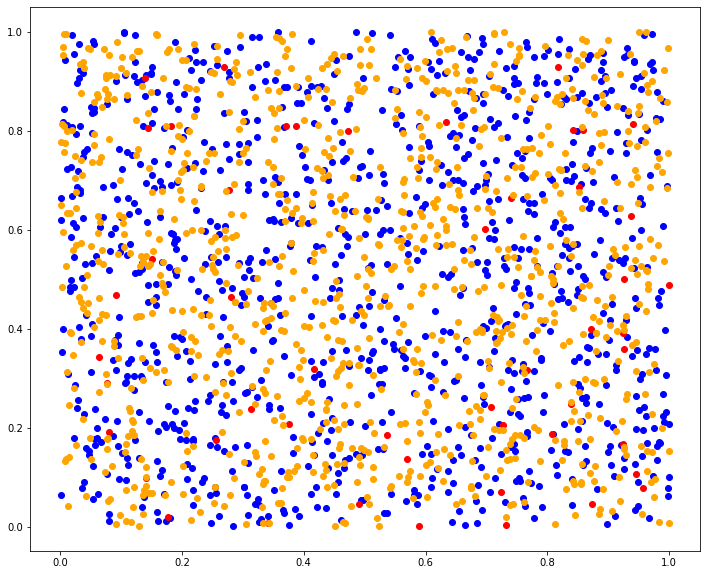

In [33]:
dim = 2
control_rate = 0.05
reference_set = np.random.random(size = (1000,dim))
control_points = np.random.random(size = (int(control_rate*reference_set.shape[0]),dim))

k = 0
test_set = np.random.random(size = (1000,dim))+k



m, s = average_inner_distance(target_points = control_points, data = reference_set)
print(f'm:\n{m}\ns:\n{s}')

i_m = dataset_intersection_counter(target_reference_points = control_points, radius = m+2*s, target_dataset =  test_set)
print(f'Intersection measure: {i_m}')

f = plt.figure(figsize = (12,10))
a = f.add_subplot(111)
a.scatter(reference_set[:,0],reference_set[:,1],color = 'blue',label='Reference Set')
a.scatter(control_points[:,0],control_points[:,1],color = 'red',label='Control Points')
a.scatter(test_set[:,0],test_set[:,1],color = 'orange',label='Test Set')